In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import datetime

import sys
sys.path.append('src')

In [14]:
from gecko.data import JPEGDataLoader

In [15]:
loader = JPEGDataLoader(camera='c2')

In [16]:
loader.base_url

'https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/+++++++++++/c2/'

In [8]:
loader.download_full_date(datetime.date(2023,12,10))

In [21]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [125]:
img_pil = Image.open(
    '/home/artkra/PERSONAL/sungrazer/gecko/data/soho/jpeg/c2/20231210/20231210_0000_c2_1024.jpg'
).convert('RGBA') 
img_pil.putalpha(200)
img = np.asarray(img_pil)


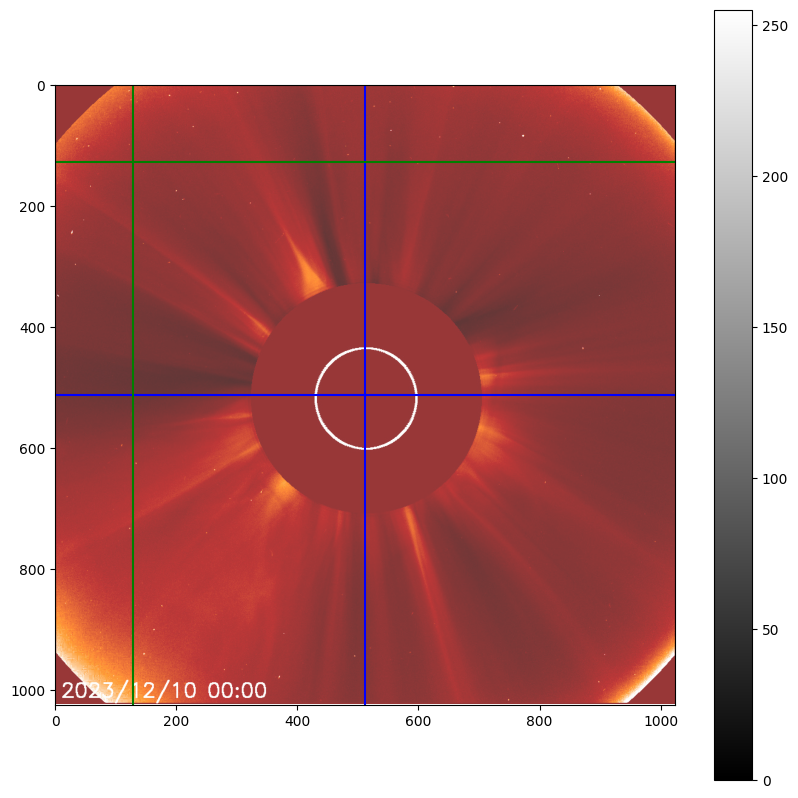

In [126]:
fig, ax = plt.subplots(figsize=(10, 10), sharex=True, sharey=True)
ax.axhline(2<<8, color='blue')
ax.axvline(2<<8, color='blue')
ax.axhline(2<<6, color='green')
ax.axvline(2<<6, color='green')

imgplot = plt.imshow(img, cmap='gray')
plt.colorbar()

In [47]:
2<<8

512